In [1]:
!pip install datasets
!pip install rouge
!pip install rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=dd363286c9236642409fa36be0fa4ea2b7e6d99ff77f8bba577b1bae2e833c6f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import nltk
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from google.colab import drive
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = load_dataset("reddit_tifu", "long")

features = df["train"].features

for x, y in features.items():
    print(f"{x}: {y.dtype}")

Generating train split:   0%|          | 0/42139 [00:00<?, ? examples/s]

ups: float32
num_comments: float32
upvote_ratio: float32
score: float32
documents: string
tldr: string
title: string


In [4]:
df = df.map(lambda element: {'summary': element['tldr'], 'text': element['documents']})
df = df.remove_columns(["ups", "upvote_ratio", "num_comments", "score", "title", "tldr", "documents"])

Map:   0%|          | 0/42139 [00:00<?, ? examples/s]

In [5]:
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    sen = text.lower()
    sen = re.sub(r'http\S+|www\S+|https\S+', '', sen)
    sen = re.sub(r'\([^)]*\)', '', sen)
    sen = re.sub('"','', sen)
    sen = re.sub("[^a-zA-Z]", " ", sen)

    words = []
    for w in sen.split():
      if not w in stop_words:
        words.append(lemmatizer.lemmatize(w))

    return (" ".join(words)).strip()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
max_text_length = 450
max_summary_length = 23

short_text = []
short_summary = []
for text, summary in zip(df['train']['text'][:10000], df['train']['summary'][:10000]):
    neat_text = clean_text(text)
    neat_summary = clean_text(summary)
    if len(neat_summary.split()) <= max_summary_length and len(neat_text.split()) <= max_text_length:
        short_text.append(neat_text)
        short_summary.append(neat_summary)

dataframe=pd.DataFrame({'text':short_text,'summary':short_summary})

In [8]:
dataframe['summary'] = dataframe['summary'].apply(lambda element : 'sostok '+ element + ' eostok')

In [9]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(dataframe['text']),np.array(dataframe['summary']),test_size=0.1,random_state=0,shuffle=True)

In [10]:
tokenizer = get_tokenizer('basic_english')
x_tr_tokens = [tokenizer(text) for text in x_tr]
x_val_tokens = [tokenizer(text) for text in x_val]
y_tr_tokens = [tokenizer(summary) for summary in y_tr]
y_val_tokens = [tokenizer(summary) for summary in y_val]

def yield_tokens(data_iter):
    for text in data_iter:
        yield text

vocab_xtr = build_vocab_from_iterator(yield_tokens(x_tr_tokens))
vocab_ytr = build_vocab_from_iterator(yield_tokens(y_tr_tokens), min_freq=1, specials=['<pad>', '<unk>', '<sos>', '<eos>'])

vocab_xval = build_vocab_from_iterator(yield_tokens(x_val_tokens))
vocab_yval = build_vocab_from_iterator(yield_tokens(y_val_tokens), min_freq=1, specials=['<pad>', '<unk>', '<sos>', '<eos>'])

In [11]:
x_tr_indices = [torch.tensor([vocab_xtr[token] for token in tokens]) for tokens in x_tr_tokens]
x_val_indices = [torch.tensor([vocab_xval[token] for token in tokens]) for tokens in x_val_tokens]
y_tr_indices = [torch.tensor([vocab_ytr[token] for token in tokens]) for tokens in y_tr_tokens]
y_val_indices = [torch.tensor([vocab_yval[token] for token in tokens]) for tokens in y_val_tokens]

x_tr_indices_padded = pad_sequence(x_tr_indices, batch_first=True, padding_value=0)
y_tr_indices_padded = pad_sequence(y_tr_indices, batch_first=True, padding_value=0)
x_val_indices_padded = pad_sequence(x_val_indices, batch_first=True, padding_value=0)
y_val_indices_padded = pad_sequence(y_val_indices, batch_first=True, padding_value=0)

train_dataset = TensorDataset(x_tr_indices_padded, y_tr_indices_padded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_indices_padded, y_val_indices_padded)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [12]:
class LSTMSeq2Seq2(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim, max_text_len):
        super(LSTMSeq2Seq2, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.encoder_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)
        self.encoder_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)
        self.encoder_lstm3 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=0.4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, trg):
        embedded_src = self.embedding(src)
        embedded_trg = self.embedding(trg)

        encoder_output1, (state_h1, state_c1) = self.encoder_lstm1(embedded_src)
        encoder_output2, (state_h2, state_c2) = self.encoder_lstm2(encoder_output1)
        encoder_output3, (state_h, state_c) = self.encoder_lstm3(encoder_output2)


        decoder_output, (decoder_fwd_state, decoder_back_state) = self.decoder_lstm(embedded_trg, (state_h, state_c))

        attn_scores = torch.bmm(decoder_output, encoder_output3.transpose(1, 2))
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_output3)
        output = self.fc(attn_output)

        return output


input_dim = len(vocab_xtr)
output_dim = len(vocab_ytr)
embedding_dim = 100
hidden_dim = 300
max_text_len = max(len(tokens) for tokens in x_tr_tokens)

model = LSTMSeq2Seq2(input_dim, output_dim, embedding_dim, hidden_dim, max_text_len)

print(model)


LSTMSeq2Seq2(
  (embedding): Embedding(32736, 100)
  (encoder_lstm1): LSTM(100, 300, batch_first=True, dropout=0.4)
  (encoder_lstm2): LSTM(300, 300, batch_first=True, dropout=0.4)
  (encoder_lstm3): LSTM(300, 300, batch_first=True, dropout=0.4)
  (decoder_lstm): LSTM(100, 300, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=300, out_features=10546, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.NLLLoss(ignore_index=vocab_ytr['<pad>'])

In [14]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for src, trg in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')


100%|██████████| 267/267 [02:45<00:00,  1.61it/s]


Epoch: 1/5, Loss: -27.7446


100%|██████████| 267/267 [02:44<00:00,  1.63it/s]


Epoch: 2/5, Loss: -65.8620


100%|██████████| 267/267 [02:44<00:00,  1.62it/s]


Epoch: 3/5, Loss: -100.3168


100%|██████████| 267/267 [02:44<00:00,  1.63it/s]


Epoch: 4/5, Loss: -130.9179


100%|██████████| 267/267 [02:44<00:00,  1.62it/s]

Epoch: 5/5, Loss: -166.1490


In [15]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
model.eval()
model_path = '/content/drive//My Drive/Colab Notebooks/LSTM.pth'
torch.save(model.state_dict(), model_path)

In [18]:
model.eval()

decoder_input = torch.tensor([vocab_ytr['<sos>']] * x_val_indices_padded.size(0)).unsqueeze(1)

max_summary_length = 25
with torch.no_grad():
    for i in range(max_summary_length):
        output = model(x_val_indices_padded, decoder_input)
        output_dim = output.shape[-1]
        _, next_token = torch.max(output[:, -1, :], dim=1)
        next_token = next_token.unsqueeze(1)
        decoder_input = torch.cat((decoder_input, next_token), dim=1)


In [19]:
predicted_summaries = []
for summary_indices in decoder_input:
    summary_tokens = [vocab_ytr.get_itos()[idx.item()] for idx in summary_indices]
    p_summary = ' '.join(summary_tokens[1:])
    predicted_summaries.append(p_summary)


Average ROUGE-1 score: 5.65
Average ROUGE-2 score: 0.00
Average ROUGE-L score: 5.65


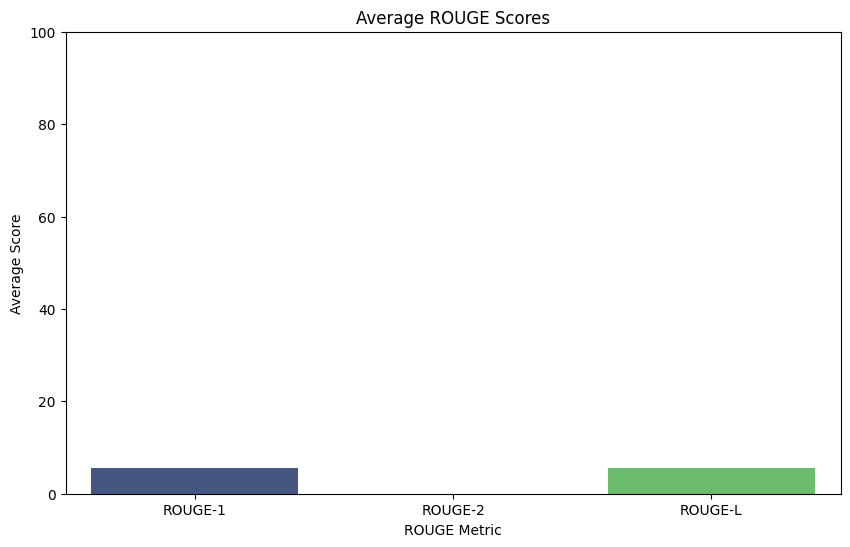

In [23]:
def calculate_rouge_scores(pred, ori):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(pred, ori) for pred, ori in zip(pred, ori)]
    return rouge_scores

original_summaries = dataframe['summary'].tolist()
rouge_scores = calculate_rouge_scores(predicted_summaries, original_summaries)


# Below code is to calculate and print average Rouge scores
average_rouge1 = (sum(scores['rouge1'].fmeasure for scores in rouge_scores) / len(rouge_scores))*100
average_rouge2 = (sum(scores['rouge2'].fmeasure for scores in rouge_scores) / len(rouge_scores))*100
average_rougeL = (sum(scores['rougeL'].fmeasure for scores in rouge_scores) / len(rouge_scores))*100


print(f"Average ROUGE-1 score: {average_rouge1:.2f}")
print(f"Average ROUGE-2 score: {average_rouge2:.2f}")
print(f"Average ROUGE-L score: {average_rougeL:.2f}")



# Below code is to plot for ROUGE scores of LSTM
plt.figure(figsize=(10, 6))
sns.barplot(x=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'], y=[average_rouge1, average_rouge2, average_rougeL], palette='viridis')
plt.title('Average ROUGE Scores')
plt.xlabel('ROUGE Metric')
plt.ylabel('Average Score')
plt.ylim(0, 100)
plt.show()